In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, r2_score
!pip install prophet --quiet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
orders = pd.read_csv('/content/drive/My Drive/Project_Final/olist_orders_dataset.csv')
order_items = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_items_dataset.csv')
customers = pd.read_csv('/content/drive/My Drive/Project_Final/olist_customers_dataset.csv')
reviews = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_reviews_dataset.csv')
payments = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_payments_dataset.csv')
products = pd.read_csv('/content/drive/My Drive/Project_Final/olist_products_dataset.csv')
sellers = pd.read_csv("/content/drive/My Drive/Project_Final/olist_sellers_dataset.csv")
geolocation = pd.read_csv("/content/drive/My Drive/Project_Final/olist_geolocation_dataset.csv")
cat_translation = pd.read_csv("/content/drive/My Drive/Project_Final/product_category_name_translation.csv")

#Kiểm tra missing và duplicate dữ liệu

In [211]:
def check_missing_and_duplicates(df, name):
    print(f"--- {name} ---")
    print("Missing:\n", df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))
    print("Duplicated:", df.duplicated().sum())
    print(df.info())
    print()

check_missing_and_duplicates(orders, "orders")
check_missing_and_duplicates(customers, "customers")
check_missing_and_duplicates(order_items, "order_items")
check_missing_and_duplicates(products, "products")
check_missing_and_duplicates(payments, "payments")
check_missing_and_duplicates(reviews, "reviews")
check_missing_and_duplicates(sellers, "sellers")
check_missing_and_duplicates(geolocation, "geo")
check_missing_and_duplicates(cat_translation, "cat_translation")

--- orders ---
Missing:
 order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
dtype: int64
Duplicated: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

--- customers ---
Missing:
 Series([], dtype: int64)
Duplicated: 0
<class 'pandas.core.fra

#Xử lý missing Orders

In [212]:
# Loại đơn chưa giao
orders = orders[orders['order_delivered_customer_date'].notnull()]
orders = orders[orders['order_delivered_carrier_date'].notnull()]

# Điền thiếu ngày xác nhận
# Với một số đơn hàng thiếu thời gian xác nhận, hệ thống giả định việc xác nhận xảy ra ngay khi đặt hàng.
orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)

/tmp/ipython-input-212-1680994181.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)
/tmp/ipython-input-212-1680994181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)


#Xử lý Missing Preview

In [213]:
# Do hơn 80% người dùng không để lại nội dung bình luận, chỉ cung cấp điểm đánh giá (review_score),
# nên hai trường review_comment_title và review_comment_message được loại bỏ trong quá trình xử lý dữ liệu
# để giảm nhiễu và tập trung vào phân tích hành vi chính.
reviews.drop(columns=['review_comment_title', 'review_comment_message'], inplace=True)

#Xử lý Missing Product

In [214]:
products['product_category_name'].fillna('unknown', inplace=True)
# Độ dài tên sản phẩm, Độ dài mô tả sản phẩm, Số ảnh sản phẩm có thể loại bỏ vì không ảnh hưởng
products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], inplace=True)
# Tính trung bình cột cân nặng, chiều cao, độ dài sản phẩm
product_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
products[product_cols] = products[product_cols].fillna(products[product_cols].mean())

/tmp/ipython-input-214-3715294945.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['product_category_name'].fillna('unknown', inplace=True)


#Xử lý kiểu dữ liệu

##Orders

In [215]:
orders['order_id'] = orders['order_id'].astype('string')
orders['customer_id'] = orders['customer_id'].astype('string')
orders['order_status'] = orders['order_status'].astype('category')

In [216]:
# Chuyển đổi kiểu ngày tháng
orders_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
               'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[orders_date] = orders[orders_date].apply(pd.to_datetime)

##Reviews

In [217]:
reviews['review_id'] = reviews['review_id'].astype('string')
reviews['order_id'] = reviews['order_id'].astype('string')

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

##Products

In [218]:
products['product_id'] = products['product_id'].astype('string')
products['product_category_name'] = products['product_category_name'].astype('string')

##Payments

In [219]:
payments['order_id'] = payments['order_id'].astype('string')
payments['payment_type'] = payments['payment_type'].astype('category')

##Order_items

In [220]:
order_items['order_id'] = order_items['order_id'].astype('string')
order_items['product_id'] = order_items['product_id'].astype('string')
order_items['seller_id'] = order_items['seller_id'].astype('string')

order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

##Customers

In [221]:
customers['customer_id'] = customers['customer_id'].astype('string')
customers['customer_unique_id'] = customers['customer_unique_id'].astype('string')
customers['customer_city'] = customers['customer_city'].astype('string')
customers['customer_state'] = customers['customer_state'].astype('string')

##Sellers

In [222]:
sellers['seller_id'] = sellers['seller_id'].astype('string')
sellers['seller_city'] = sellers['seller_city'].astype('string')
sellers['seller_state'] = sellers['seller_state'].astype('string')

##Geo

In [223]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].astype('string')
geolocation['geolocation_state'] = geolocation['geolocation_state'].astype('string')

In [224]:
cat_translation['product_category_name'] = cat_translation['product_category_name'].astype('string')
cat_translation['product_category_name_english'] = cat_translation['product_category_name_english'].astype('string')

#Merge

In [225]:
order_items['total_price'] = order_items['price'] + order_items['freight_value']

payments_agg = payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_type': lambda x: ','.join(set(x))
}).reset_index()

reviews_agg = reviews.groupby('order_id').agg({
    'review_score': 'median'
}).reset_index()

df_all = order_items.copy()

df_all = df_all.merge(orders, on='order_id', how='left')

df_all = df_all.merge(products, on='product_id', how='left')
df_all = df_all.merge(cat_translation, on='product_category_name', how='left')

df_all = df_all.merge(sellers, on='seller_id', how='left')

df_all = df_all.merge(customers, on='customer_id', how='left')

df_all = df_all.merge(payments_agg, on='order_id', how='left')

df_all = df_all.merge(reviews_agg, on='order_id', how='left')


In [226]:
df_clean = df_all.copy()

df_clean = df_clean[~df_clean["product_category_name"].isnull()]

df_clean["product_category_name_english"] = df_clean["product_category_name_english"].fillna("unknown")

size_cols = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]
for col in size_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


In [227]:
df_clean = df_clean[~df_clean['order_purchase_timestamp'].isnull()].copy()

In [228]:
df_clean = df_clean[~df_clean['payment_value'].isnull()]

In [229]:
df_clean['has_review'] = df_clean['review_score'].notnull().astype(int)

/tmp/ipython-input-229-1541678638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['has_review'] = df_clean['review_score'].notnull().astype(int)


In [230]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110192 entries, 0 to 112649
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110192 non-null  string        
 1   order_item_id                  110192 non-null  int64         
 2   product_id                     110192 non-null  string        
 3   seller_id                      110192 non-null  string        
 4   shipping_limit_date            110192 non-null  datetime64[ns]
 5   price                          110192 non-null  float64       
 6   freight_value                  110192 non-null  float64       
 7   total_price                    110192 non-null  float64       
 8   customer_id                    110192 non-null  string        
 9   order_status                   110192 non-null  category      
 10  order_purchase_timestamp       110192 non-null  datetime64[ns]
 11  order

In [231]:
df_clean['order_purchase_timestamp'] = pd.to_datetime(df_clean['order_purchase_timestamp'])

df_clean['year_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').astype(str)
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.month
df_clean['order_year'] = df_clean['order_purchase_timestamp'].dt.year
df_clean['order_date'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()
df_clean['order_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.start_time
df_clean['order_dayofweek'] = df_clean['order_purchase_timestamp'].dt.dayofweek
df_clean['order_hour'] = df_clean['order_purchase_timestamp'].dt.hour
df_clean['purchase_dayofweek'] = df_clean['order_purchase_timestamp'].dt.day_name()

In [232]:
# Tính thời gian giao hàng
df_clean['delivery_time'] = (df_clean['order_delivered_customer_date'] - df_clean['order_purchase_timestamp']).dt.days

# Tính thời gian dự kiến giao hàng
df_clean['estimated_time'] = (df_clean['order_estimated_delivery_date'] - df_clean['order_purchase_timestamp']).dt.days

# Tính độ trễ giao hàng (thực tế - dự kiến)
df_clean['delivery_delay'] = (df_clean['order_delivered_customer_date'] - df_clean['order_estimated_delivery_date']).dt.days

# Đơn hàng có bị trễ không? (1 = trễ, 0 = đúng/sớm)
df_clean['is_late'] = (df_clean['delivery_delay'] > 0).astype(int)

df_clean['delivered_late'] = df_clean['order_delivered_customer_date'] > df_clean['order_estimated_delivery_date']

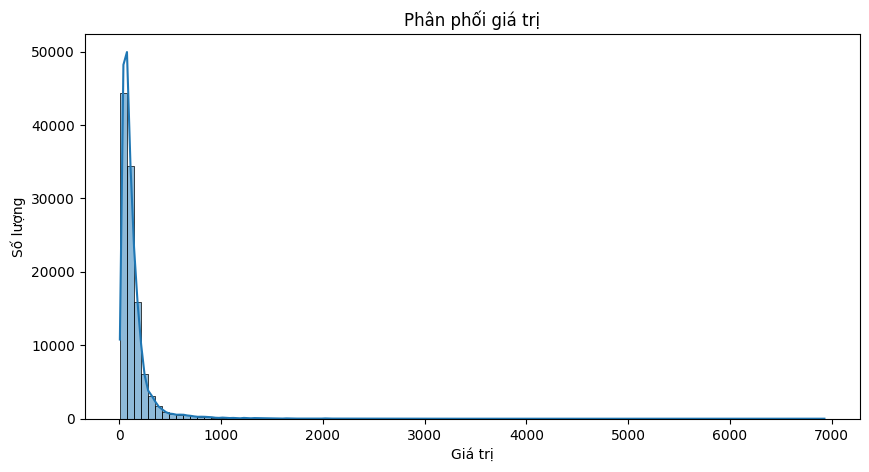

In [233]:
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['total_price'], bins=100, kde=True)
plt.title('Phân phối giá trị')
plt.xlabel('Giá trị')
plt.ylabel('Số lượng')
plt.show()

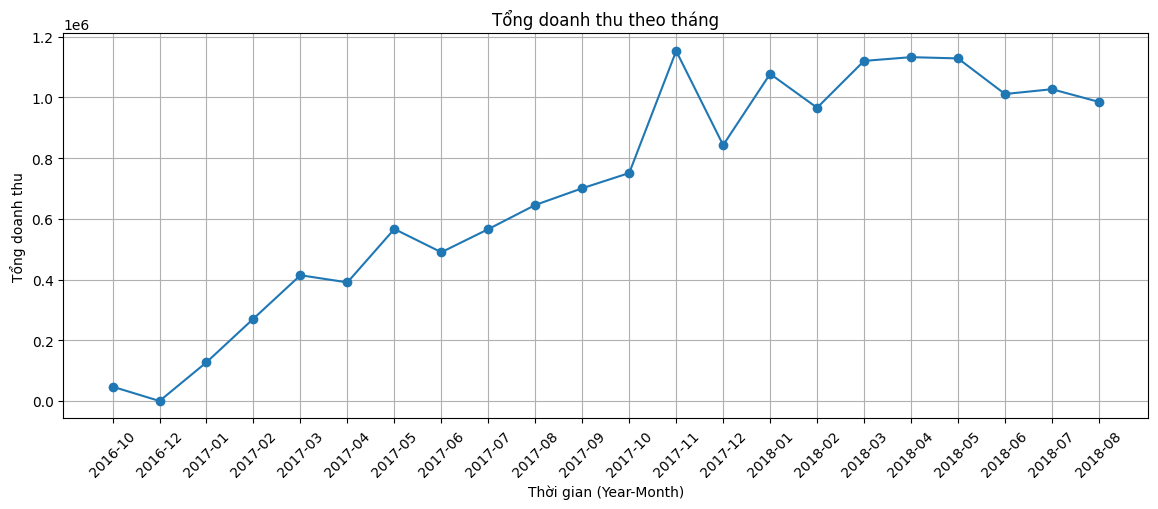

In [234]:
#Doanh thu theo tháng
monthly_revenue = df_clean.groupby(['order_year', 'order_month'])['total_price'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['order_year'].astype('string') + '-' + monthly_revenue['order_month'].astype('string').str.zfill(2)
monthly_revenue = monthly_revenue.drop(columns=['order_year', 'order_month'])

plt.figure(figsize=(14, 5))
plt.plot(monthly_revenue['year_month'], monthly_revenue['total_price'], marker='o')
plt.title('Tổng doanh thu theo tháng')
plt.xticks(rotation=45)
plt.xlabel('Thời gian (Year-Month)')
plt.ylabel('Tổng doanh thu')
plt.grid(True)
plt.show()

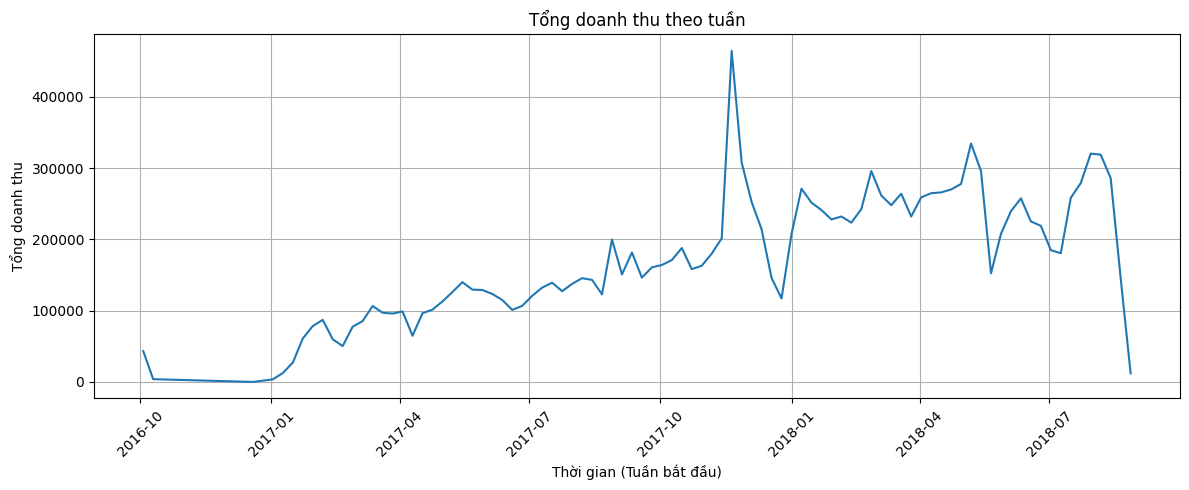

In [235]:
# Tính doanh thu theo tuần
weekly_revenue = df_clean.groupby('order_week')['total_price'].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
# weekly_revenue.plot(kind='line')
plt.plot(weekly_revenue['order_week'], weekly_revenue['total_price'])
plt.title('Tổng doanh thu theo tuần')
plt.xticks(rotation=45)
plt.xlabel('Thời gian (Tuần bắt đầu)')
plt.ylabel('Tổng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

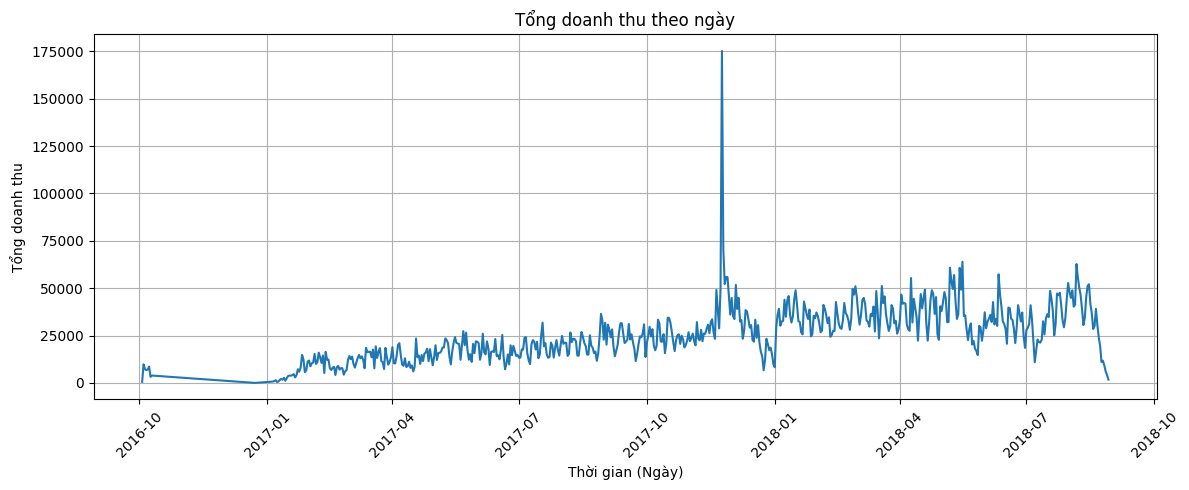

In [236]:
# Tính doanh thu theo ngày
daily_revenue = df_clean.groupby('order_date')['total_price'].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.plot(daily_revenue['order_date'], daily_revenue['total_price'])
plt.title('Tổng doanh thu theo ngày')
plt.xticks(rotation=45)
plt.xlabel('Thời gian (Ngày)')
plt.ylabel('Tổng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

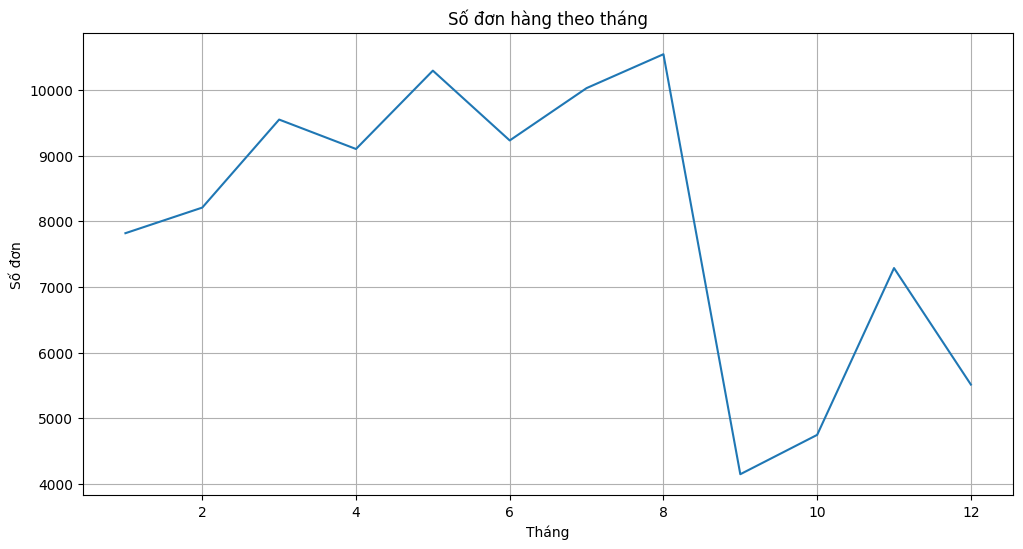

In [237]:
monthly_orders = df_clean.groupby('order_month')['order_id'].nunique()

plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line')
plt.title("Số đơn hàng theo tháng")
plt.xlabel("Tháng")
plt.ylabel("Số đơn")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

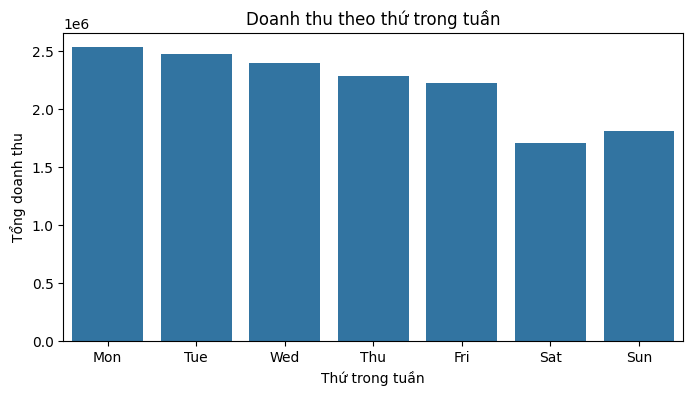

In [238]:
#Doanh thu theo thứ trong tuần
day_map = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_revenue = df_clean.groupby('order_dayofweek')['total_price'].sum().reset_index()
day_revenue['day_name'] = day_revenue['order_dayofweek'].map(lambda x: day_map[x])

plt.figure(figsize=(8, 4))
sns.barplot(data=day_revenue, x='day_name', y='total_price', order=day_map)
plt.title('Doanh thu theo thứ trong tuần')
plt.xlabel('Thứ trong tuần')
plt.ylabel('Tổng doanh thu')
plt.show()

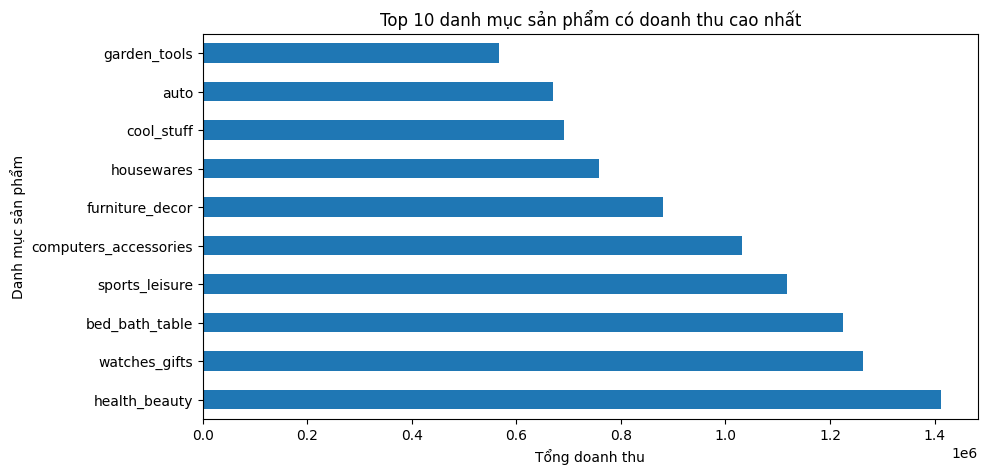

In [239]:
#Doaanh thu theo sản phẩm
top_cats = df_clean.groupby('product_category_name_english')['total_price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_cats.plot(kind='barh')
# sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title('Top 10 danh mục sản phẩm có doanh thu cao nhất')
plt.xlabel('Tổng doanh thu')
plt.ylabel('Danh mục sản phẩm')
plt.show()

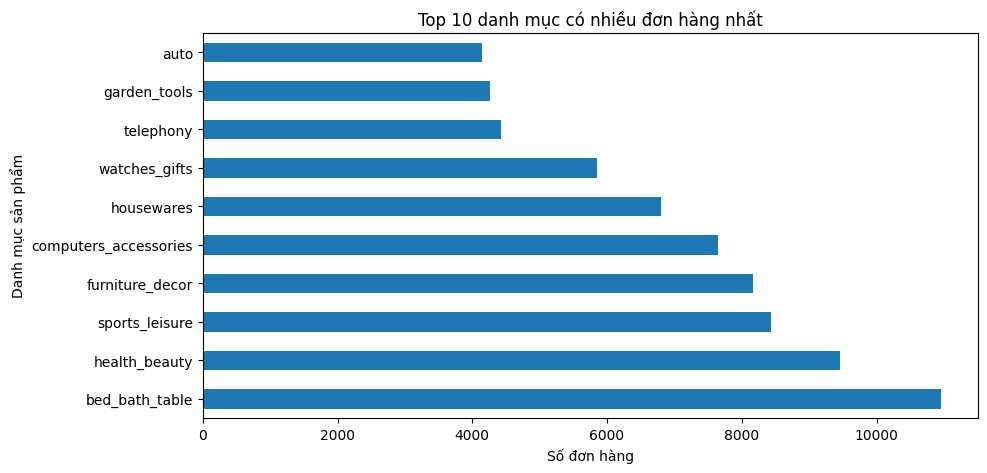

In [240]:
top_products_orders = df_clean['product_category_name_english'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_products_orders.plot(kind='barh')
plt.title("Top 10 danh mục có nhiều đơn hàng nhất")
plt.xlabel("Số đơn hàng")
plt.ylabel("Danh mục sản phẩm")
plt.show()

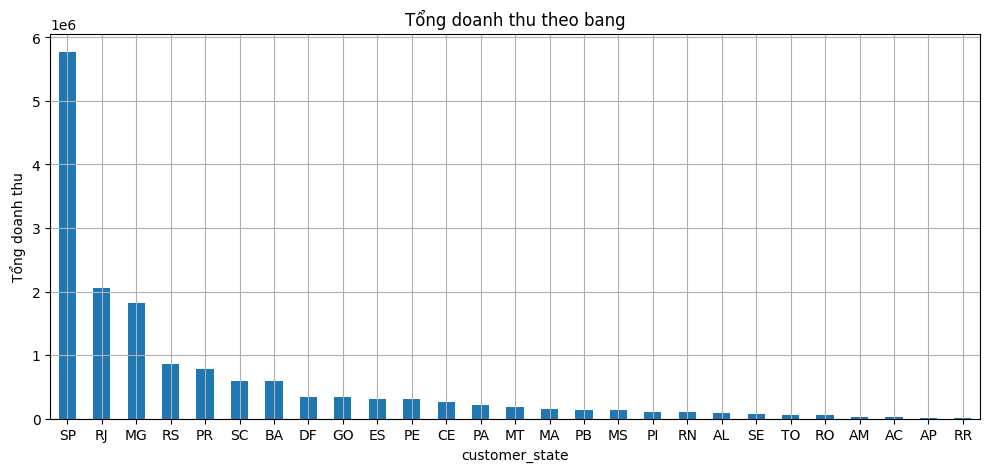

In [241]:
state_sales = df_clean.groupby('customer_state')['total_price'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,5))
state_sales.plot(kind='bar')
plt.ylabel("Tổng doanh thu")
plt.title("Tổng doanh thu theo bang")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

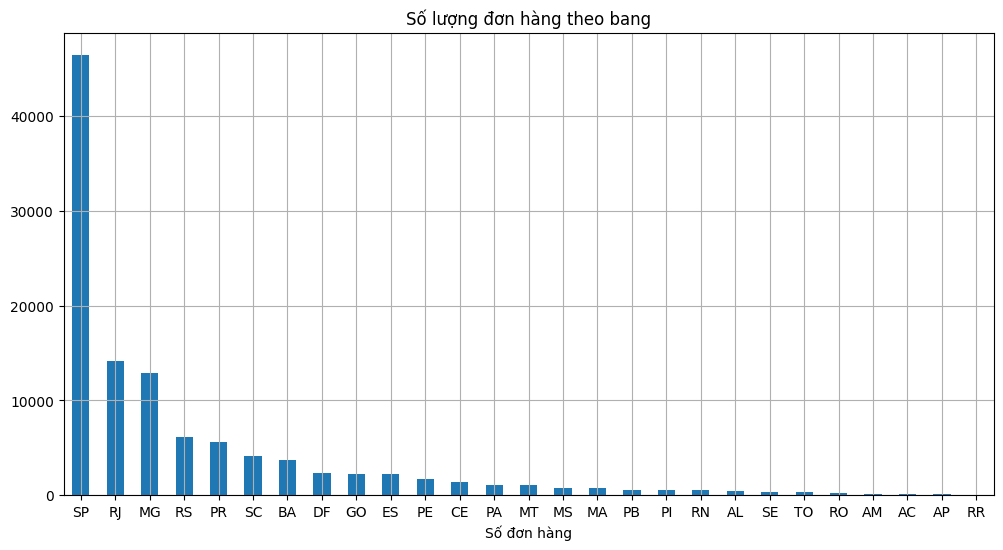

In [242]:
state_orders = df_clean['customer_state'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_orders.plot(kind='bar')
plt.title("Số lượng đơn hàng theo bang")
plt.xlabel("Số đơn hàng")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

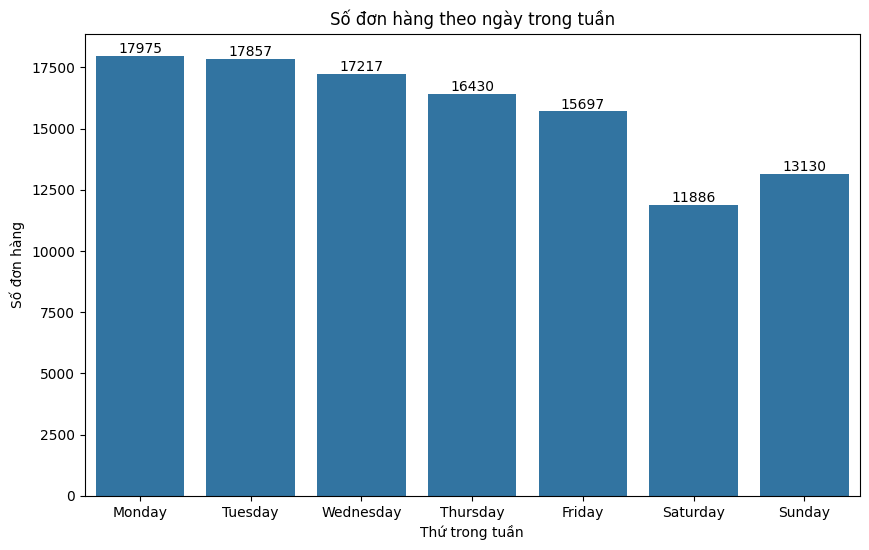

In [243]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_clean, x='purchase_dayofweek',
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title("Số đơn hàng theo ngày trong tuần")
plt.xlabel("Thứ trong tuần")
plt.ylabel("Số đơn hàng")
plt.show()

In [244]:
df_clean.groupby('purchase_dayofweek')['total_price'].sum().reset_index()

,purchase_dayofweek,total_price
0,Friday,2222392.98
1,Monday,2530173.73
2,Saturday,1705913.92
3,Sunday,1807391.64
4,Thursday,2283533.57
5,Tuesday,2473553.80
6,Wednesday,2395846.33


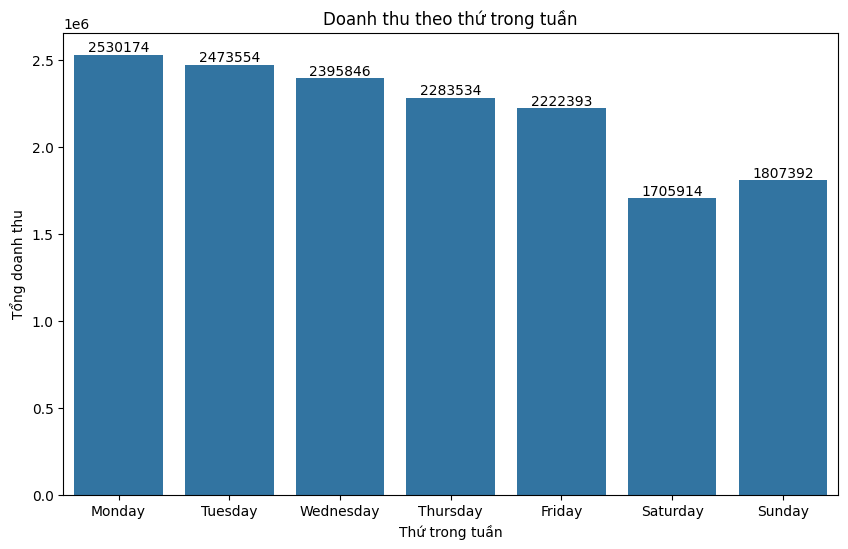

In [245]:
#Doanh thu theo thứ trong tuần
day_revenue = df_clean.groupby('purchase_dayofweek')['total_price'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=day_revenue, x='purchase_dayofweek', y='total_price',  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Doanh thu theo thứ trong tuần')
plt.xlabel('Thứ trong tuần')
plt.ylabel('Tổng doanh thu')
plt.show()

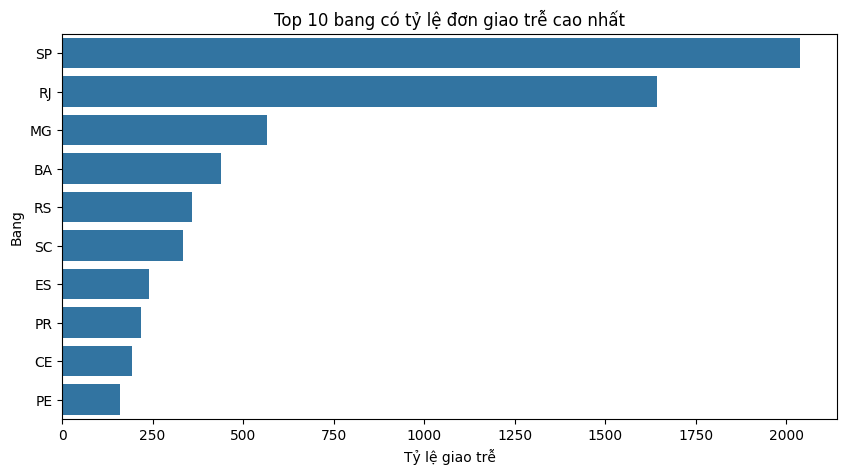

In [246]:
late_ratio_by_state = df_clean.groupby('customer_state')['is_late'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=late_ratio_by_state.values, y=late_ratio_by_state.index)
plt.title("Top 10 bang có tỷ lệ đơn giao trễ cao nhất")
plt.xlabel("Tỷ lệ giao trễ")
plt.ylabel("Bang")
plt.show()

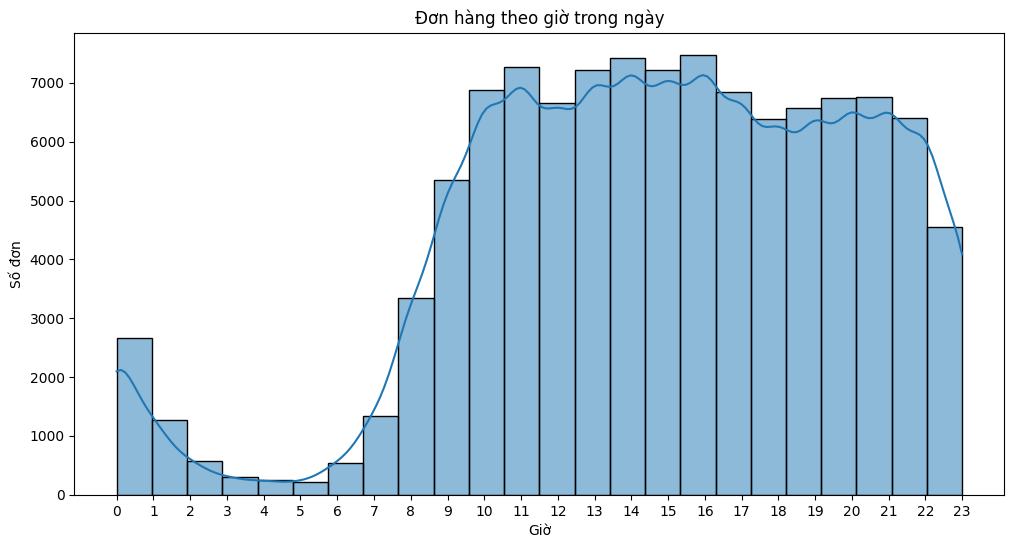

In [247]:
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['order_hour'], bins=24, kde=True)
plt.title("Đơn hàng theo giờ trong ngày")
plt.xlabel("Giờ")
plt.ylabel("Số đơn")
plt.xticks(range(0,24))
plt.show()

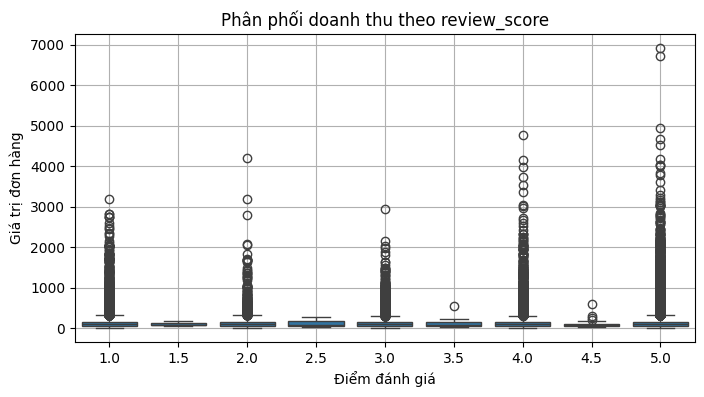

In [248]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x='review_score', y='total_price')
plt.title('Phân phối doanh thu theo review_score')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Giá trị đơn hàng')
plt.grid(True)
plt.show()

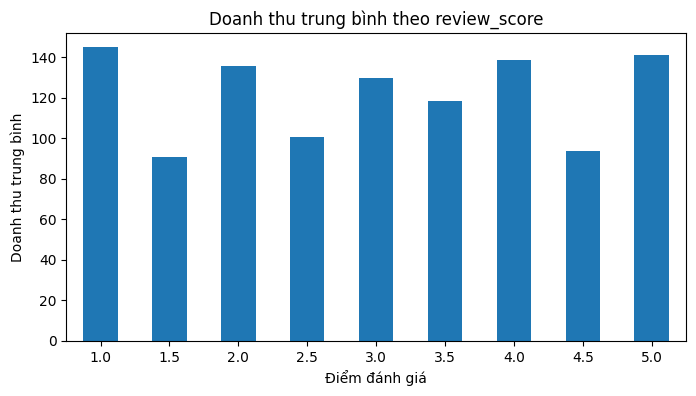

In [249]:
df_clean.groupby('review_score')['total_price'].mean().plot(kind='bar', figsize=(8, 4), title='Doanh thu trung bình theo review_score')
plt.xticks(rotation=0)
plt.xlabel('Điểm đánh giá')
plt.ylabel('Doanh thu trung bình')
plt.show()


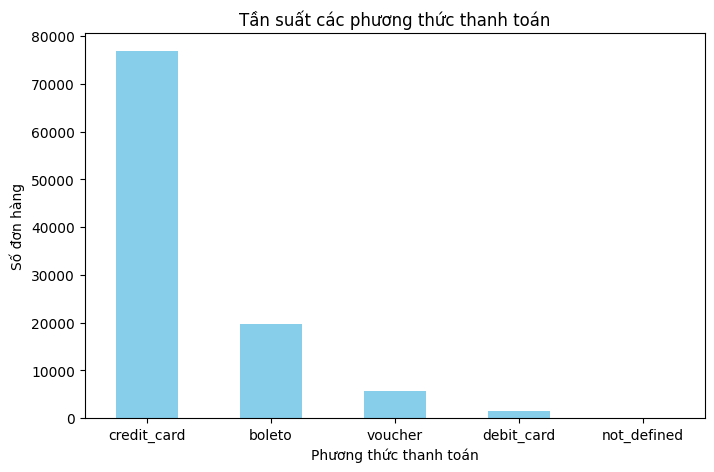

In [250]:
payment_fre = payments['payment_type'].value_counts()
plt.figure(figsize=(8, 5))
payment_fre.plot(kind='bar', color='skyblue')
plt.title("Tần suất các phương thức thanh toán")
plt.xlabel("Phương thức thanh toán")
plt.ylabel("Số đơn hàng")
plt.xticks(rotation=0)
plt.show()

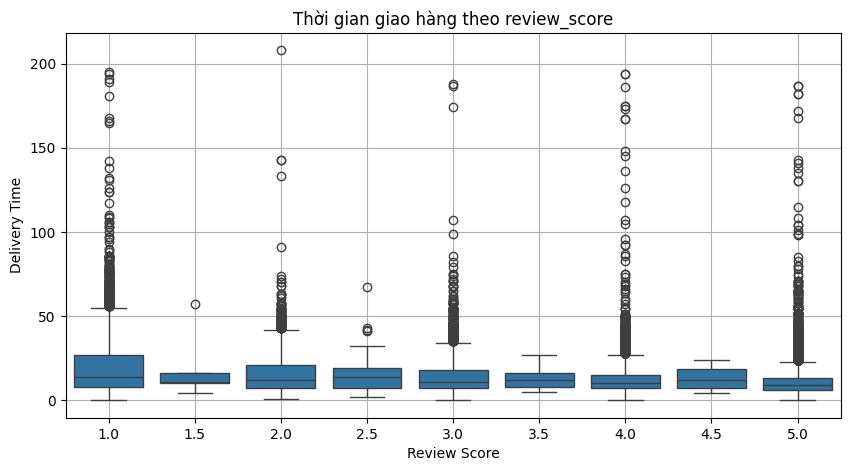

In [251]:
#Thời gian giao hàng với review
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean, x='review_score', y='delivery_time')
plt.title('Thời gian giao hàng theo review_score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time')
plt.grid(True)
plt.show()

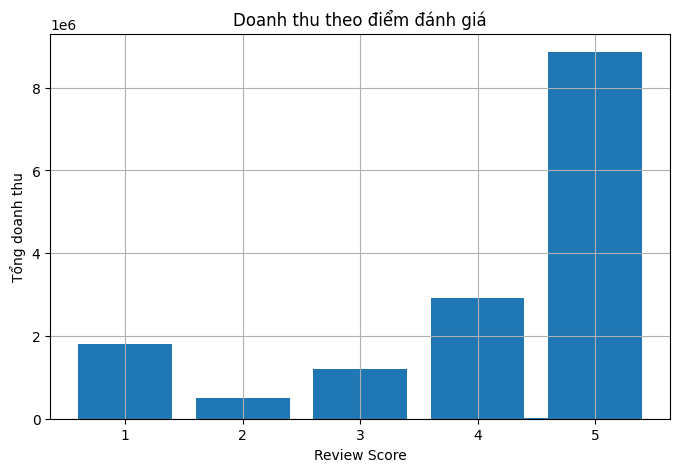

In [294]:
review_stats = df_clean.groupby('review_score')['total_price'].sum().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(review_stats['review_score'], review_stats['total_price'])
plt.xlabel("Review Score")
plt.ylabel("Tổng doanh thu")
plt.title("Doanh thu theo điểm đánh giá")
plt.grid(True)
plt.show()

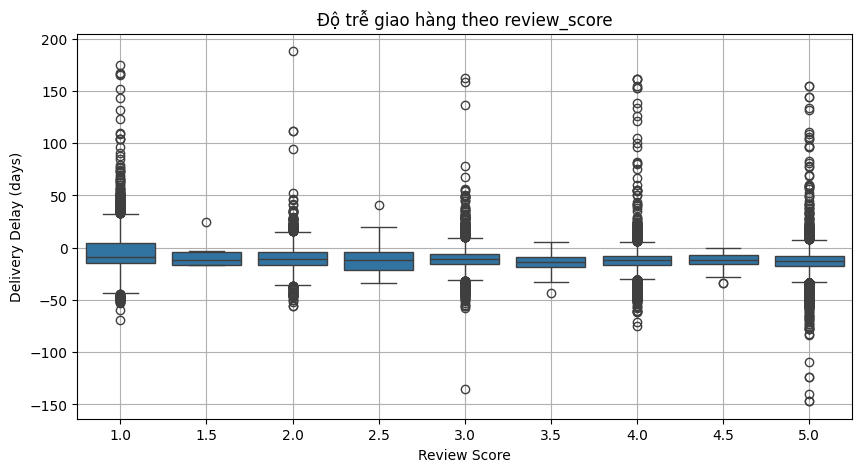

In [252]:
#Độ trễ giao hàng vs review
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean[df_clean['delivery_delay'].notnull()], x='review_score', y='delivery_delay')
plt.title('Độ trễ giao hàng theo review_score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Delay (days)')
plt.grid(True)
plt.show()

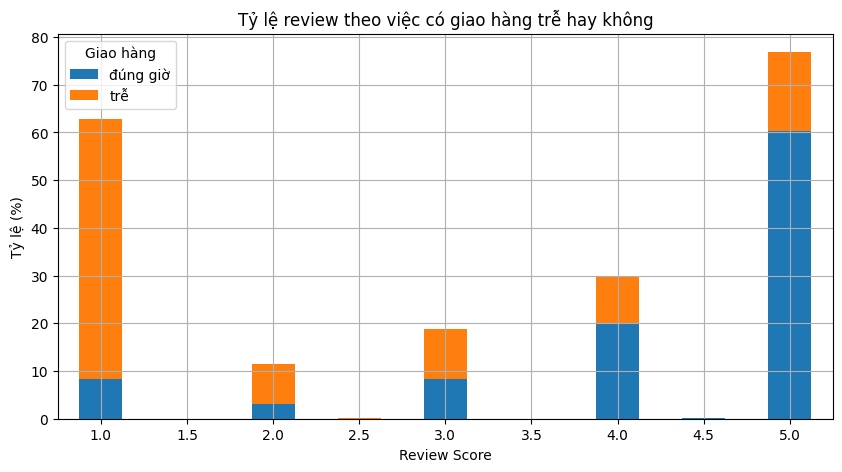

In [253]:
late_review = df_clean.groupby(['is_late', 'review_score']).size().unstack().fillna(0)

late_review_percent = late_review.div(late_review.sum(axis=1), axis=0) * 100

late_review_percent.T.plot(kind='bar', figsize=(10, 5), stacked=True)
plt.title('Tỷ lệ review theo việc có giao hàng trễ hay không')
plt.xlabel('Review Score')
plt.ylabel('Tỷ lệ (%)')
plt.legend(['đúng giờ', 'trễ'], title='Giao hàng')
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

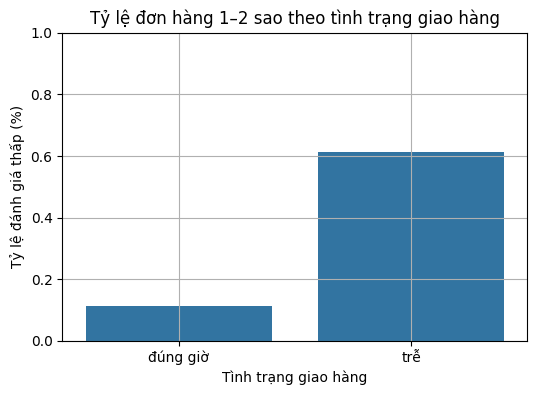

In [254]:
#Trễ giao hàng có làm tăng đơn hàng 1–2 sao
df_clean['low_review'] = df_clean['review_score'].isin([1, 2]).astype(int)

# Tính tỷ lệ đơn review thấp giữa nhóm trễ và không trễ
late_review_rate = df_clean.groupby('is_late')['low_review'].mean().reset_index()
late_review_rate.columns = ['is_late', 'low_review_rate']

plt.figure(figsize=(6, 4))
sns.barplot(data=late_review_rate, x='is_late', y='low_review_rate')
plt.xticks([0, 1], ['đúng giờ', 'trễ'])
plt.title('Tỷ lệ đơn hàng 1–2 sao theo tình trạng giao hàng')
plt.ylabel('Tỷ lệ đánh giá thấp (%)')
plt.xlabel('Tình trạng giao hàng')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [255]:
# Tổng doanh thu toàn bộ
total_revenue = df_clean['total_price'].sum()

# Doanh thu từ đơn 1–2 sao
low_review_revenue = df_clean[df_clean['review_score'].isin([1, 2])]['total_price'].sum()

# Tỷ lệ
low_review_ratio = low_review_revenue / total_revenue

print(f"Tổng doanh thu: {total_revenue:,.2f}")
print(f"Doanh thu từ đơn hàng review 1–2 sao: {low_review_revenue:,.2f}")
print(f"Tỷ lệ doanh thu từ khách không hài lòng: {low_review_ratio*100:.2f}%")

Tổng doanh thu: 15,418,805.97
Doanh thu từ đơn hàng review 1–2 sao: 2,298,098.49
Tỷ lệ doanh thu từ khách không hài lòng: 14.90%


In [256]:
df_clean[df_clean['review_score'].isin([1, 2])].sort_values(by='total_price', ascending=False).head(10)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,customer_id,order_status,...,order_week,order_dayofweek,order_hour,purchase_dayofweek,delivery_time,estimated_time,delivery_delay,is_late,delivered_late,low_review
56663,80dfedb6d17bf23539beeef3c768f4d7,1,4ca7b91a31637bd24fb8e559d5e015e4,59417c56835dd8e2e72f91f809cd4092,2017-05-05 20:50:13,3999.00,195.76,4194.76,926b6a6fb8b6081e00b335edaf578d35,delivered,...,2017-04-17,1,20,Tuesday,15,27,-12,0,False,1
95091,d7a2c0c1ff66b314f3bf166fb4157fd4,1,2b69866f22de8dad69c976771daba91c,6bd69102ab48df500790a8cecfc285c2,2017-11-26 22:39:22,2990.00,194.55,3184.55,c26acf0451e0f8ec1f5218731b9a51cf,delivered,...,2017-11-20,0,22,Monday,52,28,23,1,True,1
36878,53c71d3953507c6239ff73917ed358c9,1,17d98fc630d23a628ec1130f8d69d1d2,f9244d45189d3a3605499abddeade7d5,2018-08-13 20:55:31,3109.99,74.35,3184.34,26dcb450c4b5b390e79e6d5d0f2c6535,delivered,...,2018-07-23,1,20,Tuesday,8,27,-19,0,False,1
23765,362aa88dd1265e7b4ea491b5836fb5f6,1,d7324d4c913e7b424cb61675dafc8c10,6750d71153f00fc58829af2a8ef1bcf1,2017-05-23 02:10:12,2799.00,28.00,2827.00,1be0dd2f660a5a04ee20d608075f1b83,delivered,...,2017-05-15,1,17,Tuesday,12,36,-24,0,False,1
20400,2ec398158cb686267b1f4b102129098e,1,15151e8a937f6a4d1a4f0c03c765c6f2,1444c08e64d55fb3c25f0f09c07ffcf2,2018-05-11 12:15:17,2749.00,69.74,2818.74,fced842c7dad61e8ce47b49229659718,delivered,...,2018-04-23,5,12,Saturday,10,31,-22,0,False,1
53308,794c69999774820e22c161f6dc4fef91,1,0e030462875259ec0cb868f7ecf1fd5e,abe021b01ba992245271b9aa422032df,2017-05-30 06:35:23,2740.00,54.50,2794.50,8e2c57611e09e143ec4ab76e38033bef,delivered,...,2017-05-08,1,14,Tuesday,31,42,-12,0,False,1
96305,da8be3bb62e9bf01e2e1a3bfd74ebd1a,1,cea7edf64d9e93fbf6b89cc3ba537cd9,a4b6b9b992b46e9ef863637af96e04bc,2017-04-12 13:55:17,2690.00,61.24,2751.24,3f083b9f62e687be8d84684c7d54c8db,delivered,...,2017-04-03,3,13,Thursday,31,27,4,1,True,1
77198,afc58387b17fa794fd73b0773a9f6ea7,1,3ecf69ee1fe21cfd40b30cbea549e563,59417c56835dd8e2e72f91f809cd4092,2017-07-05 06:35:14,2690.00,44.11,2734.11,19365ad6a18ccf1baf6eb71c30651096,delivered,...,2017-06-12,6,18,Sunday,17,44,-27,0,False,1
84126,bf205457ee84ab84c423d67b88239982,1,a233df9a388d27dbdfd31731d4236db0,784ba75dd9d20200c4caed3d7a77141a,2017-12-29 15:30:45,2649.99,83.64,2733.63,695476b5848d64ba0875324c88390206,delivered,...,2017-12-18,3,15,Thursday,36,26,9,1,True,1
72727,a5d11ae16578088b0fcd76de30368bdb,1,0abc19e41fdc9d6894b8cae651619253,17e34d8224d27a541263c4c64b11a56b,2018-03-21 17:15:45,2433.60,157.01,2590.61,9c5d7103954595e173781530b10d02e4,delivered,...,2018-03-12,3,16,Thursday,36,20,16,1,True,1


#Câu hỏi:

##Tại sao tỷ lệ giao hàng trễ vẫn tồn tại, nhưng doanh thu vẫn tăng đều theo thời gian?

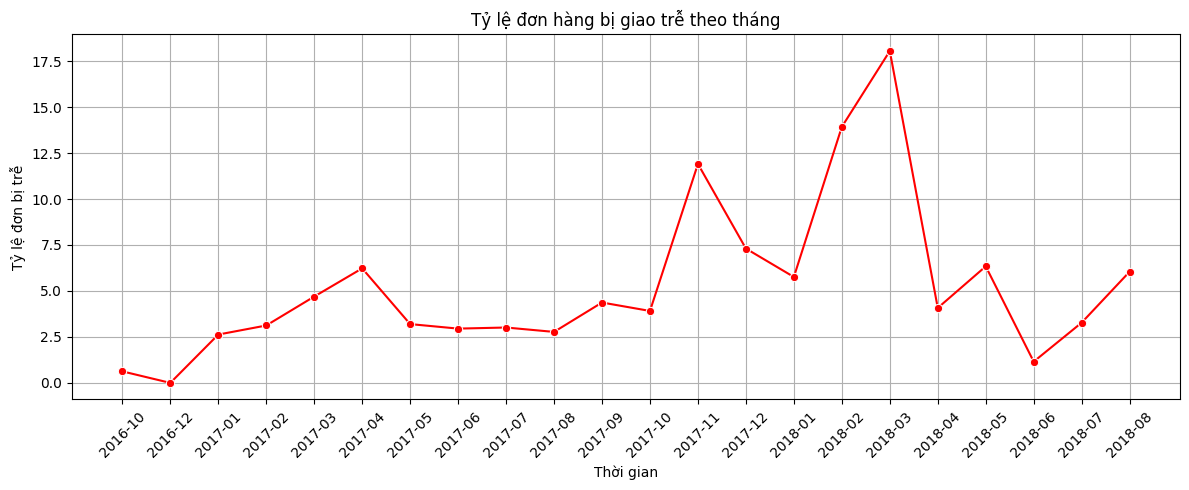

In [257]:
# Tỷ lệ đơn trễ theo tháng
monthly_late = df_clean.groupby('year_month')['is_late'].mean().reset_index()
monthly_late['is_late'] = monthly_late['is_late'] * 100

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_late, x='year_month', y='is_late', marker='o', color='red')
plt.xticks(rotation=45)
plt.title('Tỷ lệ đơn hàng bị giao trễ theo tháng')
plt.xlabel('Thời gian')
plt.ylabel('Tỷ lệ đơn bị trễ')
plt.grid(True)
plt.tight_layout()
plt.show()

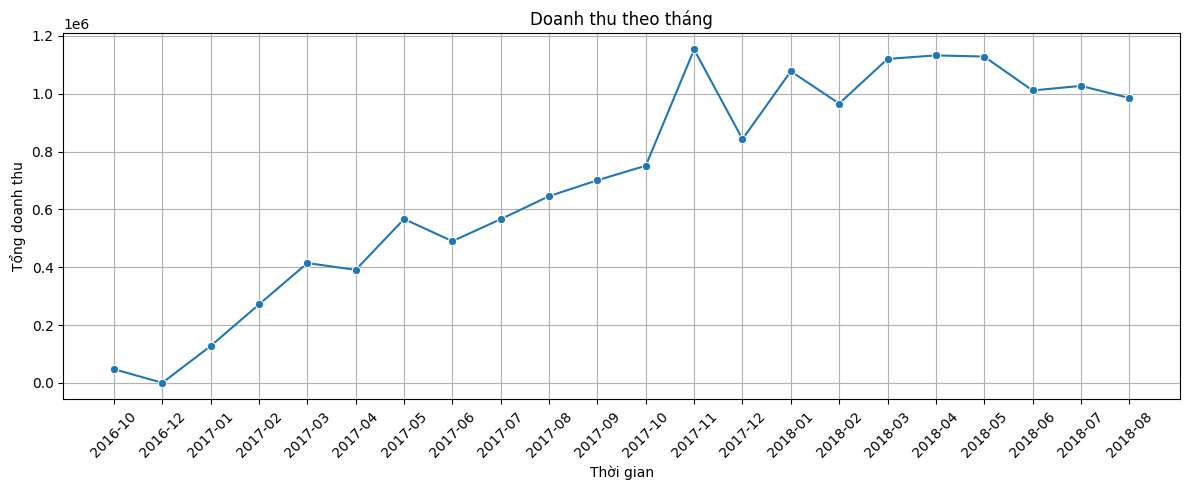

In [258]:


# Tổng doanh thu theo tháng
monthly_revenue = df_clean.groupby('year_month')['total_price'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_revenue, x='year_month', y='total_price', marker='o')
plt.xticks(rotation=45)
plt.title('Doanh thu theo tháng')
plt.xlabel('Thời gian')
plt.ylabel('Tổng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

Khi quan sát biểu đồ doanh thu theo tháng và tỷ lệ đơn hàng giao trễ, ta phát hiện:

- Tổng doanh thu tăng theo thời gian, bất chấp việc nhiều đơn bị giao trễ.

- Tuy nhiên, tỷ lệ giao trễ không giảm rõ rệt, đôi khi còn tăng nhẹ.

Điều này có thể được lý giải bởi:

- Tổng số đơn hàng tăng mạnh -> kéo doanh thu tăng, dù tỷ lệ trễ giữ nguyên

- Khách hàng chấp nhận trễ nếu giá tốt hoặc sản phẩm hiếm

- Các danh mục có doanh thu lớn (bed_bath_table, health_beauty,…) thường ít nhạy cảm với tốc độ giao hàng

- Olist vẫn chiếm thị phần tốt -> khách hàng chưa có lý do để rời bỏ

In [259]:
total_revenue = df_clean['total_price'].sum()

# Doanh thu từ đơn hàng có review 1–2 sao
low_review_revenue = df_clean[df_clean['review_score'].isin([1, 3])]['total_price'].sum()

# Tỷ lệ phần trăm
low_review_ratio = low_review_revenue / total_revenue

print(f"Tổng doanh thu: {total_revenue:,.2f} BRL")
print(f"Doanh thu từ khách không hài lòng: {low_review_revenue:,.2f} BRL")
print(f"Tỷ lệ: {low_review_ratio*100:.2f}%")

Tổng doanh thu: 15,418,805.97 BRL
Doanh thu từ khách không hài lòng: 2,997,544.87 BRL
Tỷ lệ: 19.44%


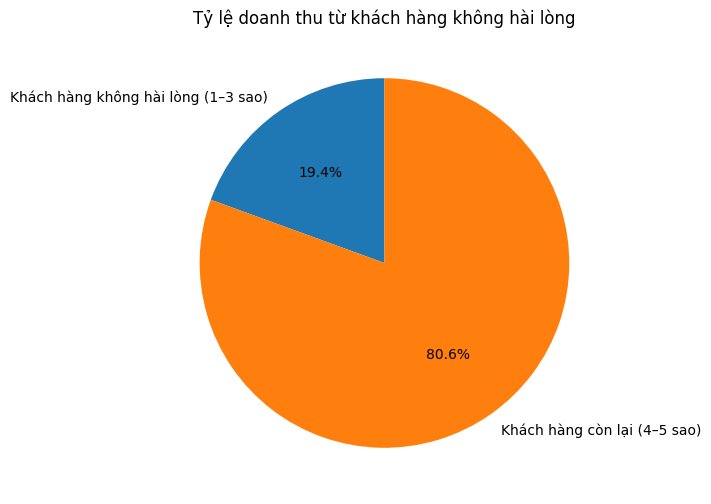

In [260]:
labels = ['Khách hàng không hài lòng (1–3 sao)', 'Khách hàng còn lại (4–5 sao)']
values = [low_review_revenue, total_revenue - low_review_revenue]
colors = ['#ff6b6b', '#4ecdc4']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Tỷ lệ doanh thu từ khách hàng không hài lòng')
plt.show()

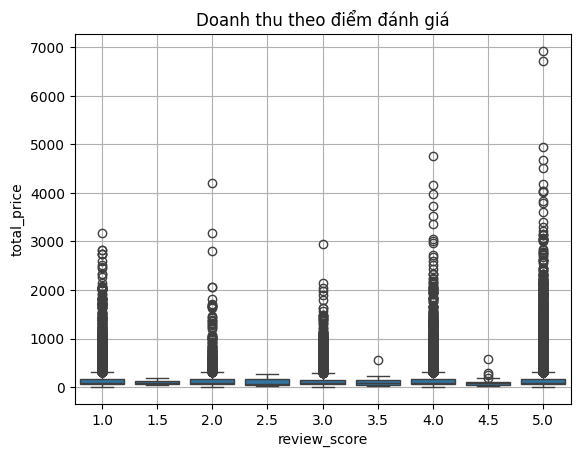

In [261]:
sns.boxplot(x='review_score', y='total_price', data=df_clean)
plt.title("Doanh thu theo điểm đánh giá")
plt.grid(True)
plt.show()

#Dự đoán

In [262]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in datetime_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        df_clean[f'{col}_day'] = df_clean[col].dt.day
        df_clean[f'{col}_month'] = df_clean[col].dt.month
        df_clean[f'{col}_weekday'] = df_clean[col].dt.weekday
        df_clean[f'{col}_hour'] = df_clean[col].dt.hour


In [263]:
df_clean['freight_ratio'] = df_clean['freight_value'] / (df_clean['total_price'] + 1e-6)
df_clean['price_per_kg'] = df_clean['total_price'] / (df_clean['product_weight_g'] + 1e-6)
df_clean['product_volume_cm3'] = df_clean['product_length_cm'] * df_clean['product_width_cm'] * df_clean['product_height_cm']
df_clean['weight_x_delay'] = df_clean['product_weight_g'] * df_clean['delivery_delay']

for col in ['total_price', 'freight_value', 'product_weight_g', 'delivery_time', 'estimated_time']:
    df_clean[f'log1p_{col}'] = np.log1p(df_clean[col])

In [264]:
features = [
    'freight_value', 'review_score', 'product_weight_g', 'delivery_delay',
    'order_month', 'order_dayofweek', 'order_hour',
    'product_category_name_english', 'payment_type',
    'seller_state', 'customer_state',

    'freight_ratio', 'price_per_kg', 'weight_x_delay', 'product_volume_cm3',
    'log1p_total_price', 'log1p_freight_value', 'log1p_product_weight_g',
    'log1p_delivery_time', 'log1p_estimated_time',
    'is_late', 'low_review',

    'order_purchase_timestamp_day',
    'order_purchase_timestamp_weekday',
    'order_purchase_timestamp_hour'
]

In [265]:
df_model = df_clean[features + ['total_price']].copy()

# Loại bỏ toàn bộ cột datetime còn sót lại
datetime_cols = df_model.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
df_model = df_model.drop(columns=datetime_cols, errors='ignore')

df_model = pd.get_dummies(df_model, drop_first=True)

# Làm sạch dữ liệu
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()
df_model = df_model.astype(float)

X = df_model.drop('total_price', axis=1)
y = df_model['total_price']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Lấy các biến có ý nghĩa thống kê (p-value ≤ 0.05)
significant_vars = model.pvalues[model.pvalues <= 0.05].index
X_significant = X[significant_vars]
model_refined = sm.OLS(y, X_significant).fit()

print(model_refined.summary())



                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2593.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        06:27:40   Log-Likelihood:            -6.6142e+05
No. Observations:              109365   AIC:                         1.323e+06
Df Residuals:                  109264   BIC:                         1.324e+06
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [266]:
# coef = model.params
# pvals = model.pvalues

# # Tạo DataFrame chứa thông tin
# summary_df = pd.DataFrame({
#     'variable': coef.index,
#     'coefficient': coef.values,
#     'p_value': pvals.values
# })

# summary_df = summary_df[summary_df['variable'] != 'const']

# # Lấy top 10 biến có ảnh hưởng mạnh nhất (dựa trên trị tuyệt đối của hệ số)
# top10 = summary_df.reindex(summary_df['coefficient'].abs().sort_values(ascending=False).index).head(10)

# # Vẽ biểu đồ
# plt.figure(figsize=(10, 6))
# bars = plt.barh(top10['variable'][::-1], top10['coefficient'][::-1], color='skyblue')
# plt.xlabel('Hệ số hồi quy')
# plt.title('Top 10 biến ảnh hưởng mạnh nhất đến doanh thu')
# plt.axvline(0, color='gray', linewidth=0.8)
# plt.tight_layout()
# plt.show()

#Dự đoán tương lai

In [267]:
df_clean['order_purchase_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
df_clean['order_purchase_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.to_timestamp()
df_clean['order_purchase_day'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()

In [268]:
# def forecast_by_time_mlr(df, time_freq='M', future_steps=6):

#     df = df.copy()
#     df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
#     df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
#     df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

#     # Tính số ngày giao trễ
#     df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
#     df['delivery_delay'] = df['delivery_delay'].fillna(0)

#     # Đảm bảo cột thời gian là cột, không phải index
#     if df.index.name == 'order_purchase_timestamp':
#         df = df.reset_index()

#     df_indexed = df.set_index('order_purchase_timestamp')

#     # Resample (gộp theo thời gian)
#     agg_df = df_indexed.resample(time_freq).agg({
#         'total_price': 'sum',
#         'freight_value': 'mean',
#         'review_score': 'mean',
#         'product_weight_g': 'mean',
#         'delivery_delay': 'mean'
#     }).dropna().reset_index()

#     # Tạo đặc trưng
#     agg_df['month'] = agg_df['order_purchase_timestamp'].dt.month
#     agg_df['time_idx'] = np.arange(len(agg_df))

#     # Biến đầu vào và mục tiêu
#     X = agg_df[['freight_value', 'review_score', 'product_weight_g', 'delivery_delay', 'month']]
#     y = agg_df['total_price']

#     model = LinearRegression()
#     model.fit(X, y)

#     # Tạo dữ liệu đầu vào cho tương lai
#     avg_vals = X.mean()
#     last_month = agg_df['month'].iloc[-1]
#     future_X = pd.DataFrame([
#         {
#             'freight_value': avg_vals['freight_value'],
#             'review_score': avg_vals['review_score'],
#             'product_weight_g': avg_vals['product_weight_g'],
#             'delivery_delay': avg_vals['delivery_delay'],
#             'month': (last_month + i - 1) % 12 + 1
#         }
#         for i in range(1, future_steps + 1)
#     ])

#     future_y = model.predict(future_X)

#     # Tạo mốc thời gian tương lai
#     last_date = agg_df['order_purchase_timestamp'].iloc[-1]
#     if time_freq == 'M':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')
#         label = 'tháng'
#     elif time_freq == 'W':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=future_steps, freq='W-MON')
#         label = 'tuần'
#     elif time_freq == 'D':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=future_steps, freq='D')
#         label = 'ngày'
#     else:
#         raise ValueError("time_freq phải là 'M', 'W', hoặc 'D'.")

#     # Vẽ biểu đồ
#     plt.figure(figsize=(10, 4))
#     plt.plot(agg_df['order_purchase_timestamp'], y, label='Doanh thu thực tế', marker='o')
#     plt.plot(future_dates, future_y, '--o', color='red', label='Dự đoán tương lai')
#     plt.title(f'Dự đoán doanh thu theo {label} (Multiple Linear Regression)')
#     plt.xlabel('Thời gian')
#     plt.ylabel('Doanh thu')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     return agg_df, model

In [269]:

# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='M', future_steps=3)

In [270]:
# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='W', future_steps=8)

In [271]:
# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='D', future_steps=30)

In [272]:
feature_cols = ['freight_value', 'review_score', 'product_weight_g', 'delivery_delay', 'month']
# X = agg_df[feature_cols]
# y = agg_df['total_price']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [273]:
from sklearn.linear_model import LinearRegression

feature_cols = X.columns
coefs = pd.Series(model.coef_, index=feature_cols)
coefs_sorted = coefs.abs().sort_values(ascending=False)

print("Top 5 biến ảnh hưởng mạnh nhất đến doanh thu:")
print(coefs[coefs_sorted.index[:5]])


Top 5 biến ảnh hưởng mạnh nhất đến doanh thu:
freight_ratio                                                          728.102572
product_category_name_english_computers                                404.684593
log1p_total_price                                                      313.712950
product_category_name_english_furniture_mattress_and_upholstery       -181.337752
product_category_name_english_small_appliances_home_oven_and_coffee    164.079601
dtype: float64


In [274]:
# plt.figure(figsize=(8, 5))
# coefs[coefs_sorted.index[:5]].sort_values().plot(kind='barh', color='skyblue')
# plt.title('Top 5 biến ảnh hưởng mạnh nhất đến doanh thu')
# plt.xlabel('Hệ số hồi quy')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

#Dùng prophet

In [275]:
# Tạo các mốc thời gian từ cột timestamp gốc
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
df_clean['order_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.start_time
df_clean['order_day'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()

# Tổng doanh thu theo từng mức độ thời gian
monthly_df = df_clean.groupby('order_month')['total_price'].sum().reset_index().rename(columns={'order_month': 'ds', 'total_price': 'y'})
weekly_df = df_clean.groupby('order_week')['total_price'].sum().reset_index().rename(columns={'order_week': 'ds', 'total_price': 'y'})
daily_df = df_clean.groupby('order_day')['total_price'].sum().reset_index().rename(columns={'order_day': 'ds', 'total_price': 'y'})


In [276]:
def forecast_revenue(df, freq, periods, granularity):
    model = Prophet()
    model.fit(df)

    try:
        df_cv = cross_validation(
            model,
            initial='365 days',
            period='90 days',
            horizon='90 days'
        )
        df_p = performance_metrics(df_cv)
        print(f"[ĐÁNH GIÁ MÔ HÌNH - {granularity}]")
        print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())
    except Exception as e:
        print("Không thể đánh giá mô hình:", e)

    # Tạo dataframe dự báo
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    # Gộp kết quả dự báo với dữ liệu thực tế
    forecast = forecast.merge(df, on='ds', how='left')
    forecast['granularity'] = granularity

    # Vẽ biểu đồ
    fig = model.plot(forecast)
    plt.title(f'Dự đoán doanh thu theo {granularity}')
    plt.xlabel('Thời gian')
    plt.ylabel('Doanh thu')
    plt.grid(True)

    # Thêm đường chia thời gian dự báo
    split_date = df['ds'].max()
    plt.axvline(x=split_date, color='gray', linestyle='--', label='Bắt đầu dự báo')
    # plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'granularity']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/ex2c5eqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/zaiqip32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59527', 'data', 'file=/tmp/tmpvrriwmmq/ex2c5eqy.json', 'init=/tmp/tmpvrriwmmq/zaiqip32.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelbu15mm3v/prophet_model-20250628062742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:42 - cmdstanpy - INFO - Chain [1] start processing
I

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/155h9dl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/wobuocgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72880', 'data', 'file=/tmp/tmpvrriwmmq/155h9dl8.json', 'init=/tmp/tmpvrriwmmq/wobuocgw.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_model9a3mlw_z/prophet_model-20250628062742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/pv1gbbub.json
DEBUG:cmdstanpy:input tempfil

[ĐÁNH GIÁ MÔ HÌNH - month]
  horizon            mae           rmse      mape  coverage
0 27 days   93315.199598  114698.958454  0.106774       0.5
1 29 days  290226.355137  290226.355137  0.286941       0.0
2 58 days   42949.587335   59527.981351  0.037951       1.0
3 59 days  338139.286536  338139.286536  0.329158       0.0
4 88 days  155846.603323  155846.603323  0.138067       0.0


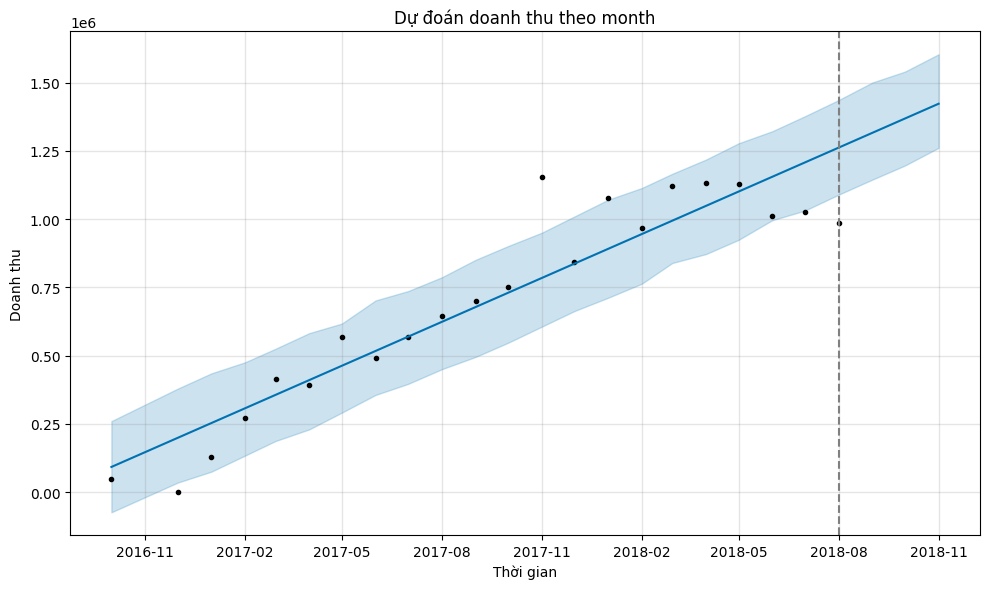

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/6w5btovz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/31hbg1me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35740', 'data', 'file=/tmp/tmpvrriwmmq/6w5btovz.json', 'init=/tmp/tmpvrriwmmq/31hbg1me.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelf8ukqbq3/prophet_model-20250628062743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:44 - cmdstanpy - INFO - Chai

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/l0qv6bji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/l8hktzsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2076', 'data', 'file=/tmp/tmpvrriwmmq/l0qv6bji.json', 'init=/tmp/tmpvrriwmmq/l8hktzsq.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_model8nxvxkip/prophet_model-20250628062744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/o7f9uvir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/0v6eiij3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[ĐÁNH GIÁ MÔ HÌNH - week]
  horizon           mae          rmse      mape  coverage
0  6 days  26461.890055  33563.111751  0.108500  1.000000
1 11 days  22756.985115  31153.444372  0.097463  1.000000
2 12 days  27736.018094  32494.917417  0.117627  1.000000
3 13 days  22827.122044  24917.039492  0.093528  1.000000
4 18 days  46876.318476  55685.901121  0.269681  0.666667


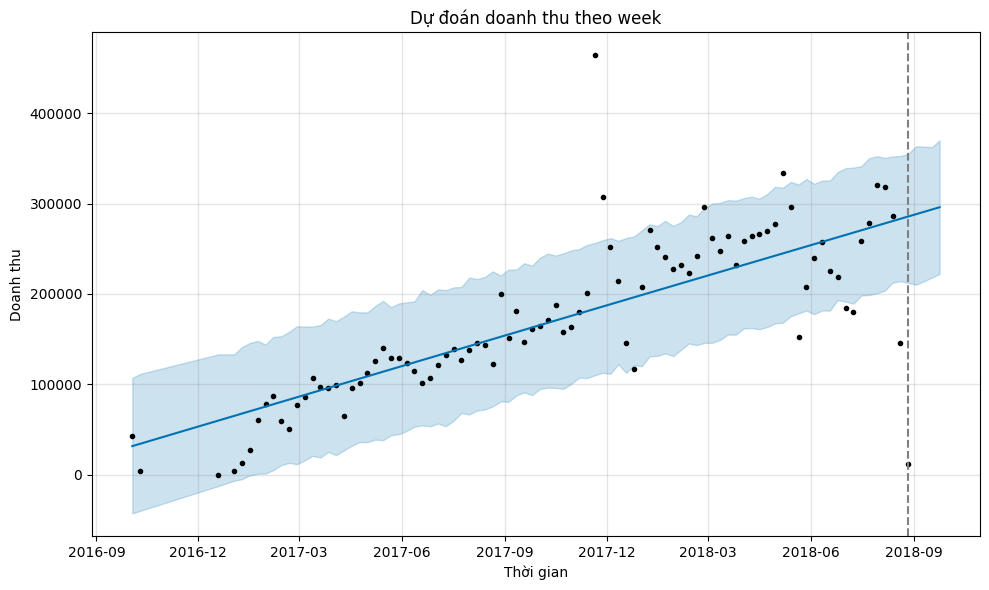

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/lrak02gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/5ssnm6sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19381', 'data', 'file=/tmp/tmpvrriwmmq/lrak02gl.json', 'init=/tmp/tmpvrriwmmq/5ssnm6sm.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelfejsuj6b/prophet_model-20250628062745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cut

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/cjzv50t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/2m7v3p8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51094', 'data', 'file=/tmp/tmpvrriwmmq/cjzv50t7.json', 'init=/tmp/tmpvrriwmmq/2m7v3p8x.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelewfxa0r_/prophet_model-20250628062746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/c6am9ep6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/vbynsmrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[ĐÁNH GIÁ MÔ HÌNH - day]
  horizon          mae         rmse      mape  coverage
0  9 days  4972.526937  5868.225180  0.147865  0.925926
1 10 days  5291.796705  6030.397517  0.157246  0.925926
2 11 days  5385.390129  6320.080913  0.157055  0.925926
3 12 days  6121.941187  7052.613256  0.183804  0.888889
4 13 days  6226.439364  7314.276996  0.187707  0.888889


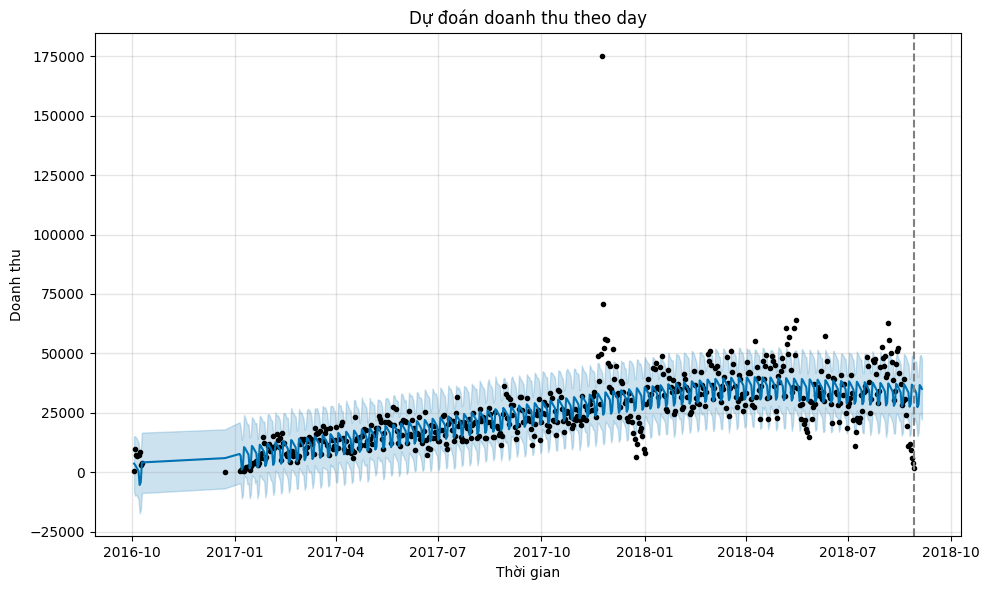

In [277]:
forecast_months = forecast_revenue(monthly_df, freq='MS', periods=3, granularity='month')
forecast_weeks  = forecast_revenue(weekly_df, freq='W-MON', periods=4, granularity='week')
forecast_days   = forecast_revenue(daily_df, freq='D', periods=7, granularity='day')

Dự báo theo "month"
- MAPE	0.08 – 0.32 (dao động mạnh)
- MAE	Lên đến 338k, có lúc chỉ 42k
- Coverage	Chỉ có 1 dòng đạt 1.0, còn lại gần 0

Nhận xét:
- Không ổn định – độ sai số lớn và coverage quá thấp

Dự báo theo "week"
- MAPE	~0.09 – 0.26
- MAE	22k–46k
- Coverage	Rất tốt (đa số đạt 1.0)

Nhận xét:
- Mô hình ổn định, độ sai số hợp lý, coverage cao
- Dự báo tuần là khá hiệu quả

Dự báo theo "day"
- MAPE	0.14 – 0.18
- MAE	4.9k – 6.2k
- Coverage	Cao (>= 0.92)

Nhận xét:
- Tốt, độ sai số tương đối thấp
- Coverage cao → mô hình ổn định

In [278]:
forecast_all = pd.concat([forecast_months, forecast_weeks, forecast_days], ignore_index=True)

In [279]:
# forecast_all.to_csv("forecast_all.csv", index=False)

In [280]:
# # Hàm tạo forecast theo từng mức thời gian
# def forecast_prophet(df, freq, label, periods, file_name):
#     df_grouped = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq=freq))['payment_value'].sum().reset_index()
#     df_grouped.columns = ['ds', 'y']
#     df_grouped = df_grouped[df_grouped['y'] > 0]  # bỏ ngày không có đơn

#     model = Prophet()
#     model.fit(df_grouped)

#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)

#     # Chỉ lấy cột cần thiết
#     output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#     output.to_csv(file_name, index=False)
#     print(f"✅ Đã lưu file: {file_name}")

# # Tạo từng file
# forecast_prophet(df_clean, freq='MS', label='tháng', periods=3, file_name='forecast_months.csv')
# forecast_prophet(df_clean, freq='W-MON', label='tuần', periods=4, file_name='forecast_weeks.csv')
# forecast_prophet(df_clean, freq='D', label='ngày', periods=7, file_name='forecast_days.csv')


In [281]:
# df_clean.to_csv('olist_data_clean.csv', index=False, encoding='utf-8-sig')

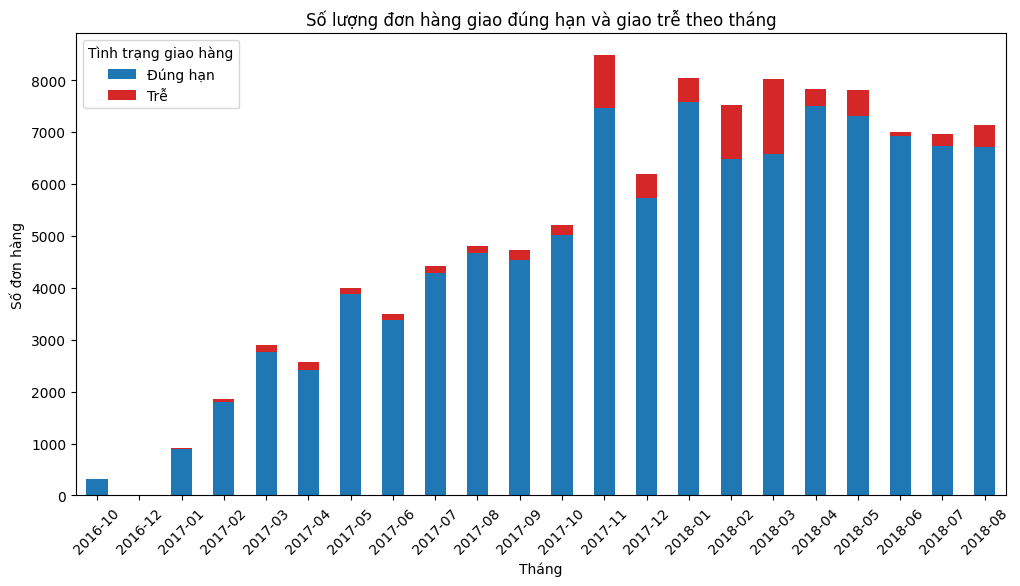

In [282]:
delay_by_month = df_clean.groupby(['order_month', 'is_late']).size().unstack(fill_value=0)
delay_by_month.index = delay_by_month.index.strftime('%Y-%m')
# Vẽ biểu đồ stacked bar chart
delay_by_month.plot(kind='bar', stacked=True,
                    color=['#1f77b4', '#d62728'], figsize=(12, 6))

plt.title('Số lượng đơn hàng giao đúng hạn và giao trễ theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số đơn hàng')
plt.xticks(rotation=45)
plt.legend(title='Tình trạng giao hàng', labels=['Đúng hạn', 'Trễ'])
plt.show()

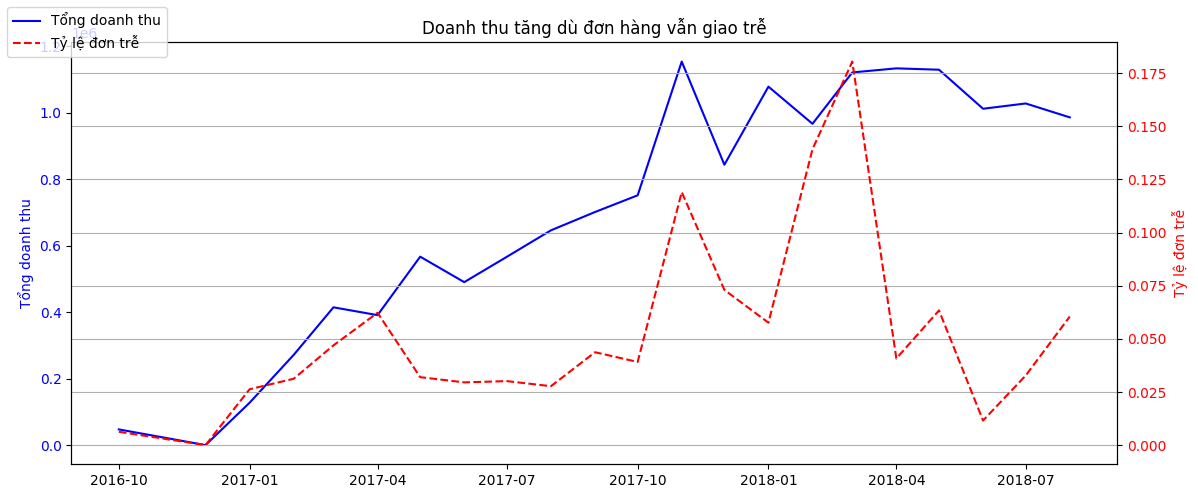

In [284]:
df1 = df_clean.copy()
monthly = df1.groupby('order_month').agg({
    'total_price': 'sum',
    'is_late': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monthly['order_month'], monthly['total_price'], color='blue', label='Tổng doanh thu')
ax1.set_ylabel('Tổng doanh thu', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(monthly['order_month'], monthly['is_late'], color='red', linestyle='--', label='Tỷ lệ đơn trễ')
ax2.set_ylabel('Tỷ lệ đơn trễ', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Doanh thu tăng dù đơn hàng vẫn giao trễ')
fig.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-287-2346187850.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freight_stats = df_clean.groupby('freight_group')['total_price'].sum().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128667 (\N{ARTICULATED LORRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


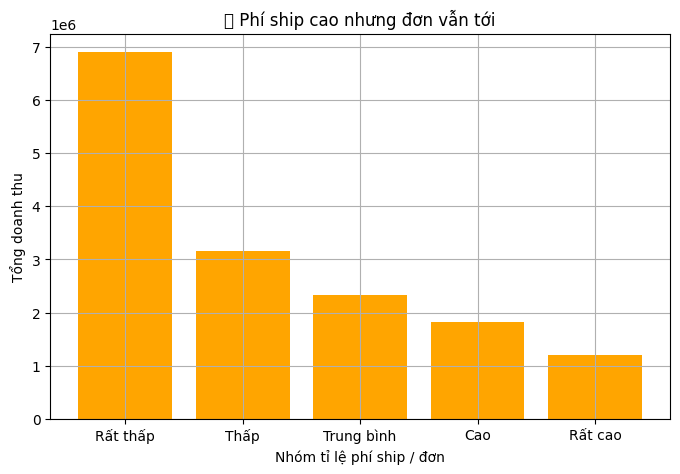

In [287]:

df_clean['freight_ratio'] = df_clean['freight_value'] / (df_clean['total_price'] + 1e-6)

# Nhóm theo mức phí vận chuyển (chia nhóm theo percentile)
df_clean['freight_group'] = pd.qcut(df_clean['freight_ratio'], q=5, labels=['Rất thấp', 'Thấp', 'Trung bình', 'Cao', 'Rất cao'])
freight_stats = df_clean.groupby('freight_group')['total_price'].sum().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(freight_stats['freight_group'], freight_stats['total_price'], color='orange')
plt.xlabel("Nhóm tỉ lệ phí ship / đơn")
plt.ylabel("Tổng doanh thu")
plt.title("🚛 Phí ship cao nhưng đơn vẫn tới")
plt.grid(True)
plt.show()